In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Import Required Libraries**

In [2]:
# Work around to get matplotlib fonts working
!pip install matplotlib==3.4.2

In [3]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.axisartist.axislines import Subplot
import seaborn as sns
from copy import copy, deepcopy
from pickle import dump, load
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis/utils')
from dimReduction import dim_reduction_PCA, elbowHeuristic_PCA
from cmeans import cmeans, optimal_fuzzifier, optimal_clusters
from cviMetrics import compute_cvi, cluster_diameter, intercluster_dist
from utils import plotClusters, calc_cluster_centroids
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import euclidean_distances

# **Import Pre-Processed Data**

In [4]:
#rawData = load(open('/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis/data/rawData_austin.pkl', 'rb'))
processedDataAustin = load(open('/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis/data/preProcessed_austin.pkl', 'rb'))
processedDataNY = load(open('/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis/data/preProcessed_newYork.pkl', 'rb'))
processedData = np.concatenate((processedDataAustin, processedDataNY), axis=0)
print(processedData.shape)

(50, 96)


# **Start with Clustering Framework**

Dimensionality Reduction

In [5]:
elbowHeuristic_PCA(processedData, random_state=56, markX=0.9804368540394404, markY=17, annotX=0.65, annotY=35,
                   figPath='/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis/results/ElbowHeuristic_PCA.pdf')
day_median_consumption_reducedPCA, nComponents = dim_reduction_PCA(processedData, 0.9804368540394404, random_state=56)
print(nComponents)

17


Clustering Algorithm

In [6]:
fuzzifierPCA = optimal_fuzzifier(day_median_consumption_reducedPCA)
nclustersFCMPCA = optimal_clusters(day_median_consumption_reducedPCA, maxClusters=10, seed=56,
                                   trials=100, fuzzifier = fuzzifierPCA, plotting=True,
                                   figPath='/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis/results/FuzzyPartitionCoefficient_PCA_FCM.pdf')
print('Optimal Clusters (PCA + Fuzzy C-Means) is: ', nclustersFCMPCA)
fcmResultsPCA = cmeans(day_median_consumption_reducedPCA, nclustersFCMPCA, fuzzifierPCA, error=0.005, maxiter=1000, seed=56)
centersFCMPCA = fcmResultsPCA[0]
fuzzyMemMatPCA = fcmResultsPCA[1]
labelsFCMPCA = np.argmax(fuzzyMemMatPCA, axis=0)

Optimal Clusters (PCA + Fuzzy C-Means) is:  9


Plot Clustering Results

In [7]:
def daily_analysis_median(complete_day_series, plotting=True, clusterLabels=None, plotNorm=False, normScale=1000, plotDir='Results'):
    median_series = np.zeros((len(complete_day_series), complete_day_series.shape[-1]))
    for houseIdx in range(len(complete_day_series)):
        temp = []
        for i in range(complete_day_series.shape[-1]):
            temp.append(complete_day_series[houseIdx,:,i][~np.isnan(complete_day_series[houseIdx,:,i])])
            median_series[houseIdx, i] = np.median(temp[i])
        if plotting:
            plt.figure(figsize=(15, 5))
            plt.boxplot(temp, flierprops = dict(marker='.', markerfacecolor='k', markersize=2, linestyle='none', markeredgecolor='k'))
            plt.plot(np.concatenate(([np.nan],median_series[houseIdx, :])), label="Median of Raw Data")
            norm = median_series[houseIdx, :] / (np.linalg.norm(median_series[houseIdx, :]))
            if plotNorm:
                plt.plot(np.concatenate(([np.nan],normScale*norm)), label="Normalized Median (Scaled Up by "+str(normScale)+")")
            locs, labels = plt.xticks()
            start = pd.Timestamp('2020-01-01')
            end = pd.Timestamp('2020-01-02')
            t = np.linspace(start.value, end.value, complete_day_series.shape[-1], endpoint=False)
            t = pd.to_datetime(t)
            newT = []
            for j in range(len(t)):
                newT.append(datetime.datetime.strptime(str(t[j]), '%Y-%m-%d %H:%M:%S').strftime('%H:%M'))
            plt.xticks(locs, newT)
            plt.xticks(rotation=30)
            plt.rc('font', size=21)         # controls default text sizes
            plt.rc('axes', titlesize=22)    # fontsize of the axes title
            plt.rc('axes', labelsize=22)    # fontsize of the x and y labels
            plt.rc('xtick', labelsize=19)   # fontsize of the tick labels
            plt.rc('ytick', labelsize=19)   # fontsize of the tick labels
            plt.rc('legend', fontsize=21)   # legend fontsize
            plt.rc('figure', titlesize=22)  # fontsize of the figure title
            plt.xlabel("Time Of The Day")
            plt.ylabel("Load Consumption (Watts)")
            if plotNorm:
                plt.legend()
            if clusterLabels is None:
                plt.savefig(plotDir+'/House'+str(houseIdx)+'Median.png', bbox_inches = 'tight', pad_inches = 0.05)
                plt.savefig(plotDir+'/House'+str(houseIdx)+'Median.pdf', bbox_inches = 'tight', pad_inches = 0.05)
            else:
                plt.savefig(plotDir+'/'+str(clusterLabels[houseIdx])+'House'+str(houseIdx)+'Median.png', bbox_inches = 'tight', pad_inches = 0.05)
                plt.savefig(plotDir+'/'+str(clusterLabels[houseIdx])+'House'+str(houseIdx)+'Median.pdf', bbox_inches = 'tight', pad_inches = 0.05)
            plt.close()
    return median_series

print(labelsFCMPCA)
#daily_analysis_median(rawData, plotting=True, clusterLabels=labelsFCMPCA, plotNorm=True, plotDir='/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis/results')
plotClusters(processedData, labelsFCMPCA, '/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis/results/cluster')

[7 5 4 6 5 0 5 5 4 4 4 6 8 5 5 5 5 6 4 5 4 5 5 6 5 6 3 3 3 4 3 2 1 6 3 3 6
 7 5 6 3 3 3 6 7 8 3 6 3 6]


In [8]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=600, init='pca', random_state=56, method='exact', learning_rate=100)
ProcessedTSNE = tsne.fit_transform(day_median_consumption_reducedPCA)
df_subset = dict()
df_subset['tsne-2d-one'] = ProcessedTSNE[:,0]
df_subset['tsne-2d-two'] = ProcessedTSNE[:,1]
plt.figure(figsize=(16,10))
plt.rc('font', size=31)         # controls default text sizes
plt.rc('axes', titlesize=32)    # fontsize of the axes title
plt.rc('axes', labelsize=32)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=29)   # fontsize of the tick labels
plt.rc('ytick', labelsize=29)   # fontsize of the tick labels
plt.rc('legend', fontsize=31)   # legend fontsize
plt.rc('figure', titlesize=32)  # fontsize of the figure title
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=labelsFCMPCA,
    palette=sns.color_palette("tab10", nclustersFCMPCA),
    data=df_subset,
    legend="full",
    alpha=0.8
)
plt.xlabel('')
plt.ylabel('')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.xlim([np.min(ProcessedTSNE[:,0]-0.2), np.max(ProcessedTSNE[:,0])+0.7])
plt.ylim([np.min(ProcessedTSNE[:,1]-0.2), np.max(ProcessedTSNE[:,1])+0.2])
plt.savefig('/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis/results/TSNE_baseline.pdf', bbox_inches = 'tight', pad_inches = 0.05)
plt.close()

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 0.310441
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.436951
[t-SNE] KL divergence after 550 iterations: 0.018010


# **Compute CVIs - Baseline**

In [9]:
cviMetrics = ['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
cviScores = []
for cviMetric in cviMetrics:
    _, metricScore = compute_cvi(day_median_consumption_reducedPCA, labelsMat=labelsFCMPCA,
                                 cvi_metric = cviMetric, dist_metric = 'euclidean',
                                 fuzzyMemMat=fuzzyMemMatPCA, fuzzifier=fuzzifierPCA)
    cviScores.append(metricScore[0])

print(cviMetrics)
print(cviScores)

['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
[0.19754912445433914, 15.477411212316253, 0.8586191413143021, 0.1571149062921333, 0.6990369386943813]


# **Finding Cluster Centroids and Radius**

In [10]:
clusterCenters = calc_cluster_centroids(day_median_consumption_reducedPCA, labelsFCMPCA)[0]
print(clusterCenters.shape)

clusterDiameters = cluster_diameter(day_median_consumption_reducedPCA, labelsFCMPCA, mode='far_centroid', dist_metric = 'euclidean')[0]
print(clusterDiameters)

clusterRadiuses = clusterDiameters/2
print(clusterRadiuses.shape)

pairwiseCentroidDist = intercluster_dist(day_median_consumption_reducedPCA, labelsFCMPCA, mode='centroid', dist_metric = 'euclidean')[0]
print(pairwiseCentroidDist.shape)
interClusterDist = np.zeros(pairwiseCentroidDist.shape)
for i in range(len(clusterRadiuses)):
    for j in range(len(clusterRadiuses)):
        if not i==j:
            interClusterDist[i,j] = pairwiseCentroidDist[i,j] - clusterRadiuses[i] - clusterRadiuses[j]
print(interClusterDist)

(9, 17)
[0.         0.         0.         0.39913556 0.52583961 0.4315135
 0.34525512 0.68673213 0.31050394]
(9,)
(9, 9)
[[ 0.          1.13502378  0.62337383  0.33669343  0.1511504   0.30188253
   0.23101933  0.40218775  0.30497941]
 [ 1.13502378  0.          1.05934787  0.61622856  0.77807304  0.60044453
   0.72229487  0.68494848  0.77155493]
 [ 0.62337383  1.05934787  0.          0.28836596  0.20991641  0.28389515
   0.30325806  0.36994367  0.48052715]
 [ 0.33669343  0.61622856  0.28836596  0.         -0.03231512 -0.18891554
  -0.19599992 -0.03009306  0.02388054]
 [ 0.1511504   0.77807304  0.20991641 -0.03231512  0.         -0.19421025
  -0.13300818  0.05854999 -0.01662122]
 [ 0.30188253  0.60044453  0.28389515 -0.18891554 -0.19421025  0.
  -0.19563127  0.04384899 -0.03339547]
 [ 0.23101933  0.72229487  0.30325806 -0.19599992 -0.13300818 -0.19563127
   0.          0.02856837 -0.02749065]
 [ 0.40218775  0.68494848  0.36994367 -0.03009306  0.05854999  0.04384899
   0.02856837  0.     

# **Making arrays for each cluster**

In [11]:
'''
Making Cluster arrays
'''
def makeClusterList(nCluster, labels, data):
    clusterList = []
    for clusterID in range(nCluster):
        temp = np.zeros((len(labels[labels==clusterID]), data.shape[1]))
        counter = 0
        for houseIdx, houseLabel in enumerate(labels):
            if houseLabel==clusterID:
                temp[counter, :] = data[houseIdx, :]
                counter += 1
        clusterList.append(temp)
    return clusterList

clusterList = makeClusterList(nclustersFCMPCA, labelsFCMPCA, day_median_consumption_reducedPCA)
print(len(clusterList)==nclustersFCMPCA, len(clusterList))
for i in range(len(clusterList)):
    print(i, clusterList[i].shape)

'''
Removing Outliers (clusters with only 1 household) from cluster list
'''
multiHouseClusterList = deepcopy(clusterList)
del multiHouseClusterList[:3]
n_clustersMHCL =  len(multiHouseClusterList)
print('Number of clusters with atleast 2 households = ', n_clustersMHCL)
for i in range(n_clustersMHCL):
    print(i, multiHouseClusterList[i].shape)

labelsMHCL = []
dataMHCL = np.array(())
for i in range(n_clustersMHCL):
    for j in range(multiHouseClusterList[i].shape[0]):
        labelsMHCL.append(i)
        if dataMHCL.shape[0]==0:
            dataMHCL = copy(multiHouseClusterList[i][j,:])
        else:
            dataMHCL = np.vstack((dataMHCL,multiHouseClusterList[i][j,:]))
labelsMHCL = np.array(labelsMHCL)
print(labelsMHCL)
print(dataMHCL.shape)

MHclusterCenters = calc_cluster_centroids(dataMHCL, labelsMHCL)[0]
print(MHclusterCenters.shape)

MHclusterDiameters = cluster_diameter(dataMHCL, labelsMHCL, mode='far_centroid', dist_metric = 'euclidean')[0]
print(MHclusterDiameters)

MHclusterRadiuses = MHclusterDiameters/2
print(MHclusterRadiuses.shape)

MHpairwiseCentroidDist = intercluster_dist(dataMHCL, labelsMHCL, mode='centroid', dist_metric = 'euclidean')[0]
print(MHpairwiseCentroidDist.shape)
MHinterClusterDist = np.zeros(MHpairwiseCentroidDist.shape)
for i in range(len(MHclusterRadiuses)):
    for j in range(len(MHclusterRadiuses)):
        if not i==j:
            MHinterClusterDist[i,j] = MHpairwiseCentroidDist[i,j] - MHclusterRadiuses[i] - MHclusterRadiuses[j]
print(MHinterClusterDist)

True 9
0 (1, 17)
1 (1, 17)
2 (1, 17)
3 (11, 17)
4 (7, 17)
5 (13, 17)
6 (11, 17)
7 (3, 17)
8 (2, 17)
Number of clusters with atleast 2 households =  6
0 (11, 17)
1 (7, 17)
2 (13, 17)
3 (11, 17)
4 (3, 17)
5 (2, 17)
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3
 3 3 3 3 3 4 4 4 5 5]
(47, 17)
(6, 17)
[0.39913556 0.52583961 0.4315135  0.34525512 0.68673213 0.31050394]
(6,)
(6, 6)
[[ 0.         -0.03231512 -0.18891554 -0.19599992 -0.03009306  0.02388054]
 [-0.03231512  0.         -0.19421025 -0.13300818  0.05854999 -0.01662122]
 [-0.18891554 -0.19421025  0.         -0.19563127  0.04384899 -0.03339547]
 [-0.19599992 -0.13300818 -0.19563127  0.          0.02856837 -0.02749065]
 [-0.03009306  0.05854999  0.04384899  0.02856837  0.          0.13981392]
 [ 0.02388054 -0.01662122 -0.03339547 -0.02749065  0.13981392  0.        ]]


# **Computing CVIs - MH Baseline**

In [12]:
cviMetrics = ['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
cviScores = []
for cviMetric in cviMetrics:
    _, metricScore = compute_cvi(dataMHCL, labelsMat=labelsMHCL,
                                 cvi_metric = cviMetric, dist_metric = 'euclidean',
                                 fuzzifier=fuzzifierPCA)
    cviScores.append(metricScore[0])

print(cviMetrics)
print(cviScores)

['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
[0.21115991837947629, 16.045737306987437, 1.112411778923952, 0.1571149062921333, 0.7436563177599801]


# **Change in Outliers**

Effect of introduction of outliers

In [13]:
'''
EXISTING RESULTS:

The effect of change in outliers = Comparison of CVI scores - baseline (outliers) and MH baseline (no outliers)

BASELINE RESULTS - with outliers:
0.19754912445433914, 15.477411212316253, 0.8586191413143021, 0.1571149062921333, 0.6990369386943813 

MH BASELINE RESULTS - without outliers:
0.21115991837947629 (better), 16.045737306987437 (better), 1.112411778923952 (worse), 0.1571149062921333 (same), 0.7436563177599801 (worse) 
'''

outlierList = deepcopy(clusterList)
del outlierList[3:]
n_outliers =  len(outlierList)
print('n_outliers = ', n_outliers)


#####
## CREATE BINARY STRINGS FOR OUTLIER PERMUTATIONS
#####
binaryStrings = np.array([None] * n_outliers)
#print(binaryStrings)
# Function to save the sequences generated by generateAllBinaryStrings
def saveTheSequence(arr, n):
    global binaryStrings
    binaryStrings = np.vstack((binaryStrings, arr))

# Function to generate all binary strings 
def generateAllBinaryStrings(n, arr, i):
    if i == n:
        saveTheSequence(arr, n)
        return
    
    # First assign "0" at ith position
    # and try for all other permutations
    # for remaining positions
    arr[i] = 0
    generateAllBinaryStrings(n, arr, i + 1)
  
    # And then assign "1" at ith position
    # and try for all other permutations
    # for remaining positions
    arr[i] = 1
    generateAllBinaryStrings(n, arr, i + 1)

generateAllBinaryStrings(n_outliers, [None]*n_outliers, 0)
binaryStrings = binaryStrings[1:]
print(binaryStrings.shape)
#####
## CREATED BINARY STRINGS FOR OUTLIER PERMUTATIONS
#####

outlierCVIs = []
for i in range(binaryStrings.shape[0]):
    dataWithOutliers = deepcopy(dataMHCL)
    labelsWithOutliers = deepcopy(labelsMHCL)
    for j in range(n_outliers):
        if binaryStrings[i,j]==1:
            dataWithOutliers = np.vstack((dataWithOutliers, outlierList[j]))
            labelsWithOutliers = np.append(labelsWithOutliers, labelsWithOutliers.max()+1)
    cviMetrics_temp = ['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
    cviScores_temp = []
    for cviMetric in cviMetrics_temp:
        _, metricScore = compute_cvi(dataWithOutliers, labelsMat=labelsWithOutliers,
                                    cvi_metric = cviMetric, dist_metric = 'euclidean',
                                    fuzzifier=fuzzifierPCA)
        cviScores_temp.append(metricScore[0])
    outlierCVIs.append(np.array(cviScores_temp))
print(cviMetrics_temp)
for i in range(len(outlierCVIs)):
    print(binaryStrings[i,:], outlierCVIs[i])

'''
RESULTS:

['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
[0 0 0] [ 0.21115992 16.04573731  1.11241178  0.15711491  0.74365632]
[0 0 1] [ 0.20676075 14.70077355  1.00859215  0.15711491  0.72816348]
[0 1 0] [ 0.20676075 17.98226021  0.99171442  0.15711491  0.72816348]
[0 1 1] [ 0.20254115 16.57250424  0.91595941  0.15711491  0.713303  ]
[1 0 0] [ 0.20578034 14.63188325  1.01062395  0.15711491  0.72816348]
[1 0 1] [ 0.20158074 13.67854263  0.93250525  0.15711491  0.713303  ]
[1 1 0] [ 0.20158074 16.53295405  0.91773724  0.15711491  0.713303  ]
[1 1 1] [ 0.19754912 15.47741121  0.85861914  0.15711491  0.69903694]

Silhouette: Worsens with addition of outliers. Biased against outliers.
CHscore:    When the outlier is closer to the clusters, CH score worsens. Whereas, when the outlier is far from the existing clusters, it improves.
            xxxxxxxxxxxxxxxxxxxxIn other words, CHscore considers the outliers closer to clusters as a part of the existing clusters and an outlier only when the 
            outlier is at very large distance.xxxxxxxxxxxxxxxxxxxx
DBscore:    Improves with the addition of outliers. Biased towards outliers.
DIscore:    Unaffected by the presence of outliers. No bias for outliers.
XBscore:    Improves with the addition of outliers. Biased towards outliers.

'''   

n_outliers =  3
(8, 3)
['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
[0 0 0] [ 0.21115992 16.04573731  1.11241178  0.15711491  0.74365632]
[0 0 1] [ 0.20676075 14.70077355  1.00859215  0.15711491  0.72816348]
[0 1 0] [ 0.20676075 17.98226021  0.99171442  0.15711491  0.72816348]
[0 1 1] [ 0.20254115 16.57250424  0.91595941  0.15711491  0.713303  ]
[1 0 0] [ 0.20578034 14.63188325  1.01062395  0.15711491  0.72816348]
[1 0 1] [ 0.20158074 13.67854263  0.93250525  0.15711491  0.713303  ]
[1 1 0] [ 0.20158074 16.53295405  0.91773724  0.15711491  0.713303  ]
[1 1 1] [ 0.19754912 15.47741121  0.85861914  0.15711491  0.69903694]


"\nRESULTS:\n\n['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']\n[0 0 0] [ 0.21115992 16.04573731  1.11241178  0.15711491  0.74365632]\n[0 0 1] [ 0.20676075 14.70077355  1.00859215  0.15711491  0.72816348]\n[0 1 0] [ 0.20676075 17.98226021  0.99171442  0.15711491  0.72816348]\n[0 1 1] [ 0.20254115 16.57250424  0.91595941  0.15711491  0.713303  ]\n[1 0 0] [ 0.20578034 14.63188325  1.01062395  0.15711491  0.72816348]\n[1 0 1] [ 0.20158074 13.67854263  0.93250525  0.15711491  0.713303  ]\n[1 1 0] [ 0.20158074 16.53295405  0.91773724  0.15711491  0.713303  ]\n[1 1 1] [ 0.19754912 15.47741121  0.85861914  0.15711491  0.69903694]\n\nSilhouette: Worsens with addition of outliers. Biased against outliers.\nCHscore:    When the outlier is closer to the clusters, CH score worsens. Whereas, when the outlier is far from the existing clusters, it improves.\n            xxxxxxxxxxxxxxxxxxxxIn other words, CHscore considers the outliers closer to clusters as a part of the existing clusters 

# **Change in Density**

Effect of change in density per cluster

1.   Increase Density using Multivariate Gaussian Distribution
2.   Compute CVIs - Density 
3.   Check the increased density from tsne plot



In [14]:
######################################
'''
For data with clusters having 2 or more hoseholds only (outlier removal)
'''
######################################
nTrials = 100
MHavgCVIscore = np.zeros((len(cviMetrics)))
for k in range(nTrials):
    '''
    Fitting multivariate gaussian in each cluster
    '''
    MHlabelsSynthetic = []
    MHdataSynthetic = np.array(())
    nPtsPerCluster = 10
    for i in range(n_clustersMHCL):
        if not multiHouseClusterList[i].shape[0] == 1:
            MHfinPts = np.array(())
            while not MHfinPts.shape[0] == nPtsPerCluster:
                MHnewPts = np.random.multivariate_normal(MHclusterCenters[i], np.cov(multiHouseClusterList[i], rowvar=False)/9,
                                                    size=nPtsPerCluster, check_valid='warn', tol=1e-8)
                for j in range(nPtsPerCluster):
                    if euclidean_distances(MHnewPts[j,:].reshape(1,-1), MHclusterCenters[i,:].reshape(1,-1))[0,0] <= MHclusterRadiuses[i]:
                        if MHfinPts.shape[0]<nPtsPerCluster:
                            if MHfinPts.shape[0]==0:
                                MHfinPts = MHnewPts[j,:].reshape(1,-1)
                            else:
                                MHfinPts = np.vstack((MHfinPts, MHnewPts[j,:].reshape(1,-1)))
                #print(i, MHfinPts.shape)
            for j in range(nPtsPerCluster):
                MHlabelsSynthetic.append(i)
            if MHdataSynthetic.shape[0]==0:
                MHdataSynthetic = MHfinPts
            else:
                MHdataSynthetic = np.vstack((MHdataSynthetic, MHfinPts))
    MHlabelsSynthetic = np.array(MHlabelsSynthetic)
    #print(labelsSynthetic.shape)
    #print(labelsSynthetic)
    #print(dataSynthetic.shape)

    MHdensityData = np.concatenate((dataMHCL, MHdataSynthetic ), axis=0)
    #print(densityData.shape)
    MHdensityLabel = np.concatenate((labelsMHCL, MHlabelsSynthetic ), axis=0)
    #print(densityLabel.shape)
    '''
    Calculating CVI scores
    '''
    cviMetrics = ['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
    MHcviScores = []
    for cviMetric in cviMetrics:
        _, metricScore = compute_cvi(MHdensityData, labelsMat=MHdensityLabel,
                                    cvi_metric = cviMetric, dist_metric = 'euclidean',
                                    fuzzifier=fuzzifierPCA)
        MHcviScores.append(metricScore[0])
    MHavgCVIscore = ((MHavgCVIscore*(k+1))+np.array(MHcviScores))/(k+2)
    #print(cviMetrics)
    #print(cviScores)
print(cviMetrics)
print(MHavgCVIscore)
# 0.19754912445433914, 15.477411212316253, 0.8586191413143021, 0.1571149062921333, 0.6990369386943813 (BASELINE RESULTS)
# 0.21115991837947629, 16.045737306987437, 1.112411778923952, 0.1571149062921333, 0.7436563177599801    (MH BASELINE RESULTS)
# 0.43593196(better), 102.94081978(better),   0.78012004 (better),   0.15091861 (worse),   0.39980704 (better). (MH INCREASED DENSITY RESULTS)

['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
[  0.46245138 102.35996101   0.72046657   0.15491438   0.40086656]


In [24]:
'''
Plotting comparison between MH Baseline Results and Increased Density Results
'''
cviMHbaseline = np.array([0.21115991837947629, 16.045737306987437, 1.112411778923952, 0.1571149062921333, 0.7436563177599801])
cviMHincreasedDensity = np.array([0.46245138, 102.35996101, 0.72046657, 0.15491438, 0.40086656])
cviLabels = ['SH (\u2191)', 'CH (\u2191)', 'DB (\u2193)', 'DI (\u2191)', 'XB (\u2193)']

index = np.arange(5)
bar_width = 0.35

plt.figure(figsize=(16,10))
plt.rc('font', size=31)         # controls default text sizes
plt.rc('axes', titlesize=32)    # fontsize of the axes title
plt.rc('axes', labelsize=32)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=29)   # fontsize of the tick labels
plt.rc('ytick', labelsize=29)   # fontsize of the tick labels
plt.rc('legend', fontsize=31)   # legend fontsize
plt.rc('figure', titlesize=32)  # fontsize of the figure title
ax = plt.axes()
ax.yaxis.grid(True)
ax.yaxis.set_zorder(0)
ax.bar(index, cviMHbaseline, width=bar_width, color='#A4A4EE', log=True, label='Baseline', zorder=3)
ax.bar(index+bar_width, cviMHincreasedDensity, width=bar_width, color='#66CDAA', log=True, label='Increased Density', zorder=3)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(cviLabels)
ax.legend()
plt.savefig('/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis/results/incDensityBarGraph.pdf', bbox_inches = 'tight', pad_inches = 0.05)
plt.close()

In [16]:
######################################
'''
For full data - No removal of outlier households
'''
######################################
nTrials = 100
avgCVIscore = np.zeros((len(cviMetrics)))
for k in range(nTrials):
    '''
    Fitting multivariate gaussian in each cluster
    '''
    labelsSynthetic = []
    dataSynthetic = np.array(())
    nPtsPerCluster = 10
    for i in range(nclustersFCMPCA):
        if not clusterList[i].shape[0] == 1:
            finPts = np.array(())
            while not finPts.shape[0] == nPtsPerCluster:
                newPts = np.random.multivariate_normal(clusterCenters[i], np.cov(day_median_consumption_reducedPCA, rowvar=False)/16,
                                                    size=nPtsPerCluster, check_valid='warn', tol=1e-8)
                for j in range(nPtsPerCluster):
                    if euclidean_distances(newPts[j,:].reshape(1,-1), clusterCenters[i,:].reshape(1,-1))[0,0] <= clusterRadiuses[i]:
                        if finPts.shape[0]<nPtsPerCluster:
                            if finPts.shape[0]==0:
                                finPts = newPts[j,:].reshape(1,-1)
                            else:
                                finPts = np.vstack((finPts, newPts[j,:].reshape(1,-1)))
                #print(i, finPts.shape)
            for j in range(nPtsPerCluster):
                labelsSynthetic.append(i)
            if dataSynthetic.shape[0]==0:
                dataSynthetic = finPts
            else:
                dataSynthetic = np.vstack((dataSynthetic, finPts))
    labelsSynthetic = np.array(labelsSynthetic)
    #print(labelsSynthetic.shape)
    #print(labelsSynthetic)
    #print(dataSynthetic.shape)

    densityData = np.concatenate((day_median_consumption_reducedPCA, dataSynthetic ), axis=0)
    #print(densityData.shape)
    densityLabel = np.concatenate((labelsFCMPCA, labelsSynthetic ), axis=0)
    #print(densityLabel.shape)
    '''
    Calculating CVI scores
    '''
    cviMetrics = ['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
    cviScores = []
    for cviMetric in cviMetrics:
        _, metricScore = compute_cvi(densityData, labelsMat=densityLabel,
                                    cvi_metric = cviMetric, dist_metric = 'euclidean',
                                    fuzzifier=fuzzifierPCA)
        cviScores.append(metricScore[0])
    avgCVIscore = ((avgCVIscore*(k+1))+np.array(cviScores))/(k+2)
    #print(cviMetrics)
    #print(cviScores)
print(cviMetrics)
print(avgCVIscore)
#0.19754912445433914, 15.477411212316253, 0.8586191413143021, 0.1571149062921333, 0.6990369386943813 (BASELINE RESULTS)
#0.40617494 (Better), 71.77339214 (Better),  0.61481968 (Better),  0.14472617 (Worse),  0.41400352 (Better) (INCREASED DENSITY RESULTS)

['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
[ 0.40948597 72.03792064  0.60930564  0.14559242  0.40278547]


In [17]:
'''
TSNE plot to confirm same seperation and increased density (MH DATA)
'''
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=600, init='pca', random_state=56, method='exact', learning_rate=100)
ProcessedTSNE = tsne.fit_transform(MHdensityData)
df_subset = dict()
df_subset['tsne-2d-one'] = ProcessedTSNE[:,0]
df_subset['tsne-2d-two'] = ProcessedTSNE[:,1]
plt.figure(figsize=(16,10))
plt.rc('font', size=31)         # controls default text sizes
plt.rc('axes', titlesize=32)    # fontsize of the axes title
plt.rc('axes', labelsize=32)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=29)   # fontsize of the tick labels
plt.rc('ytick', labelsize=29)   # fontsize of the tick labels
plt.rc('legend', fontsize=31)   # legend fontsize
plt.rc('figure', titlesize=32)  # fontsize of the figure title
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=MHdensityLabel,
    palette=sns.color_palette("tab10", n_clustersMHCL),
    data=df_subset,
    legend="full",
    alpha=0.8
)
plt.xlabel('')
plt.ylabel('')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.xlim([np.min(ProcessedTSNE[:,0]-0.2), np.max(ProcessedTSNE[:,0])+0.2])
plt.ylim([np.min(ProcessedTSNE[:,1]-0.2), np.max(ProcessedTSNE[:,1])+0.2])
plt.savefig('/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis/results/TSNE_density.pdf', bbox_inches = 'tight', pad_inches = 0.05)
plt.close()

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 107 / 107
[t-SNE] Mean sigma: 0.155741
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.733414
[t-SNE] KL divergence after 600 iterations: 0.064846


# **Change in Diameter and Seperation**

effect of reduction in diameter by 20%

In [18]:
######################################
'''
For data with clusters having 2 or more hoseholds only (post outlier removal)
'''
'''
Removing Outliers (clusters with only 1 household) from cluster list
'''
multiHouseClusterList = deepcopy(clusterList)
del multiHouseClusterList[:3]
n_clustersMHCL =  len(multiHouseClusterList)
print('Number of clusters with atleast 2 households = ', n_clustersMHCL)
for i in range(n_clustersMHCL):
    print(i, multiHouseClusterList[i].shape)

labelsMHCL = []
dataMHCL = np.array(())
for i in range(n_clustersMHCL):
    for j in range(multiHouseClusterList[i].shape[0]):
        labelsMHCL.append(i)
        if dataMHCL.shape[0]==0:
            dataMHCL = copy(multiHouseClusterList[i][j,:])
        else:
            dataMHCL = np.vstack((dataMHCL,multiHouseClusterList[i][j,:]))
labelsMHCL = np.array(labelsMHCL)
print(labelsMHCL)
print(dataMHCL.shape)

######################################
nTrials = 100
reducedMHavgCVIscore = np.zeros((len(cviMetrics)))
'''
Variables obtained after outlier removal:
    - multiHouseClusterList : List of clusters arrays
    - dataMHCL              : Household feature vectors in PCA reduced dimensions which are not outliers
    - labelsMHCL            : Cluster labels corresponding to dataMHCL
    - MHclusterCenters      : Cluster centroid of remaining clusters given by (dataMHCL, labelsMHCL)
    - MHclusterDiameters    : Cluster diameters (far_centroid) of remaining clusters given by (dataMHCL, labelsMHCL)
    - MHclusterRadiuses     : Cluster radiuses of remaining clusters given by (dataMHCL, labelsMHCL)
    - MHinterClusterDist    : Pairwise inter-cluster distances
'''
reducedDiameterProportion   = 0.8
reducedMHclusterDiameters   = reducedDiameterProportion*MHclusterDiameters
reducedMHclusterRadiuses    = reducedMHclusterDiameters/2
for k in range(nTrials):
    '''
    Fitting multivariate gaussian in each cluster
    '''
    reducedMHlabelsSynthetic = []
    reducedMHdataSynthetic = np.array(())
    nPtsPerCluster = 0
    reducedDataMHCL = np.array(())
    reducedLabelsMHCL = []
    for i in range(n_clustersMHCL):
        if not multiHouseClusterList[i].shape[0] == 1: #Just for caution - although unnecessary at this stage
            # Only keep those houses which fall under the cluster of reduced diameter
            reducedPts = 0
            for j in range(multiHouseClusterList[i].shape[0]):
                if euclidean_distances(multiHouseClusterList[i][j,:].reshape(1,-1), MHclusterCenters[i,:].reshape(1,-1))[0,0] <= reducedMHclusterRadiuses[i]:
                    reducedLabelsMHCL.append(i)
                    if reducedDataMHCL.shape[0]==0:
                        reducedDataMHCL = copy(multiHouseClusterList[i][j,:])
                    else:
                        reducedDataMHCL = np.vstack((reducedDataMHCL,multiHouseClusterList[i][j,:]))
                else:
                    reducedPts += 1
            
            reducedMHfinPts = np.array(())
            while not reducedMHfinPts.shape[0] == nPtsPerCluster+reducedPts:
                reducedMHnewPts = np.random.multivariate_normal(MHclusterCenters[i], np.cov(multiHouseClusterList[i], rowvar=False)/16,
                                                    size=nPtsPerCluster+reducedPts, check_valid='warn', tol=1e-8)
                for j in range(nPtsPerCluster+reducedPts):
                    if euclidean_distances(reducedMHnewPts[j,:].reshape(1,-1), MHclusterCenters[i,:].reshape(1,-1))[0,0] <= reducedMHclusterRadiuses[i]:
                        if reducedMHfinPts.shape[0]<nPtsPerCluster+reducedPts:
                            if reducedMHfinPts.shape[0]==0:
                                reducedMHfinPts = reducedMHnewPts[j,:].reshape(1,-1)
                            else:
                                reducedMHfinPts = np.vstack((reducedMHfinPts, reducedMHnewPts[j,:].reshape(1,-1)))
                #print(i, reducedMHfinPts.shape)
            for j in range(nPtsPerCluster+reducedPts):
                reducedMHlabelsSynthetic.append(i)
            if reducedMHdataSynthetic.shape[0]==0:
                reducedMHdataSynthetic = reducedMHfinPts
            else:
                reducedMHdataSynthetic = np.vstack((reducedMHdataSynthetic, reducedMHfinPts))
    reducedMHlabelsSynthetic = np.array(reducedMHlabelsSynthetic)
    #print(reducedMHlabelsSynthetic.shape)
    #print(reducedMHlabelsSynthetic)
    #print(reducedMHdataSynthetic.shape)

    reducedMHdensityData = np.concatenate((reducedDataMHCL, reducedMHdataSynthetic ), axis=0)
    #print(reducedMHdensityData.shape)
    reducedMHdensityLabel = np.concatenate((np.array(reducedLabelsMHCL), reducedMHlabelsSynthetic ), axis=0)
    #print(reducedMHdensityLabel.shape)

    '''
    Remove points far from cluster centroid
    '''
    
    '''
    Calculating CVI scores
    '''
    cviMetrics = ['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
    reducedMHcviScores = []
    for cviMetric in cviMetrics:
        _, metricScore = compute_cvi(reducedMHdensityData, labelsMat=reducedMHdensityLabel,
                                    cvi_metric = cviMetric, dist_metric = 'euclidean',
                                    fuzzifier=fuzzifierPCA)
        reducedMHcviScores.append(metricScore[0])
    reducedMHavgCVIscore = ((reducedMHavgCVIscore*(k+1))+np.array(reducedMHcviScores))/(k+2)
    #print(cviMetrics)
    #print(cviScores)
print(cviMetrics)
print(reducedMHavgCVIscore)
print(cviScores)
# 0.19754912445433914, 15.477411212316253, 0.8586191413143021, 0.1571149062921333, 0.6990369386943813 (BASELINE RESULTS)
# 0.21115991837947629, 16.045737306987437, 1.112411778923952, 0.1571149062921333, 0.7436563177599801    (MH BASELINE RESULTS)
# 0.43593196(better), 102.94081978(better),   0.78012004 (better),   0.15091861 (worse),   0.39980704 (better). (MH INCREASED DENSITY RESULTS)

Number of clusters with atleast 2 households =  6
0 (11, 17)
1 (7, 17)
2 (13, 17)
3 (11, 17)
4 (3, 17)
5 (2, 17)
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3
 3 3 3 3 3 4 4 4 5 5]
(47, 17)
['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
[ 0.36033877 32.33992127  0.78539509  0.33797247  0.39922532]
[0.40377033681009417, 74.81364880917272, 0.6316341250571174, 0.1571149062921333, 0.44086757735202187]


In [26]:
'''
Plotting comparison between MH Baseline Results and Reduced Diameter Results
'''
cviMHbaseline = np.array([0.21115991837947629, 16.045737306987437, 1.112411778923952, 0.1571149062921333, 0.7436563177599801])
cviMHreducedDia = np.array([0.3620613, 32.76832953, 0.7821589, 0.34059641, 0.39664638])
cviLabels = ['SH (\u2191)', 'CH (\u2191)', 'DB (\u2193)', 'DI (\u2191)', 'XB (\u2193)']

index = np.arange(5)
bar_width = 0.35

plt.figure(figsize=(16,10))
plt.rc('font', size=31)         # controls default text sizes
plt.rc('axes', titlesize=32)    # fontsize of the axes title
plt.rc('axes', labelsize=32)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=29)   # fontsize of the tick labels
plt.rc('ytick', labelsize=29)   # fontsize of the tick labels
plt.rc('legend', fontsize=31)   # legend fontsize
plt.rc('figure', titlesize=32)  # fontsize of the figure title
ax = plt.axes()
ax.yaxis.grid(True)
ax.yaxis.set_zorder(0)
ax.bar(index, cviMHbaseline, width=bar_width, color='#A4A4EE', log=True, label='Baseline', zorder=3)
ax.bar(index+bar_width, cviMHreducedDia, width=bar_width, color='#66CDAA', log=True, label='Increased Separation', zorder=3)
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(cviLabels)
ax.legend()
plt.savefig('/content/drive/My Drive/Colab Notebooks/Load Demand Clustering Analysis/results/incSepBarGraph.pdf', bbox_inches = 'tight', pad_inches = 0.05)
plt.close()

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 47 / 47
[t-SNE] Mean sigma: 0.311074
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.831012
[t-SNE] KL divergence after 600 iterations: 0.058699


<AxesSubplot:xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

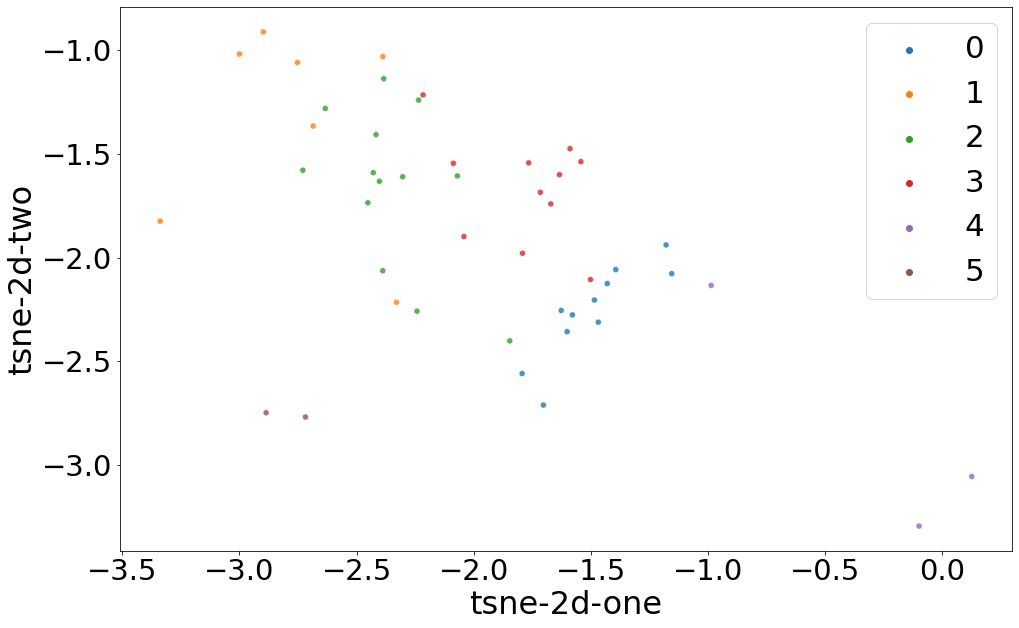

In [20]:
'''
TSNE plot to confirm decreased diameter and better clustering (reducedMH DATA)
'''
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=600, init='pca', random_state=56, method='exact', learning_rate=100)
ProcessedTSNE = tsne.fit_transform(reducedMHdensityData)
df_subset = dict()
df_subset['tsne-2d-one'] = ProcessedTSNE[:,0]
df_subset['tsne-2d-two'] = ProcessedTSNE[:,1]
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=reducedMHdensityLabel,
    palette=sns.color_palette("tab10", n_clustersMHCL),
    data=df_subset,
    legend="full",
    alpha=0.8
)

# **Change in Sub-Clustering**
effect of increased size of 1 cluster as compared to other counterparts

In [21]:
######################################
'''
For data with clusters having 2 or more hoseholds only (post outlier removal)
'''
'''
Removing Outliers (clusters with only 1 household) from cluster list
'''
multiHouseClusterList = deepcopy(clusterList)
del multiHouseClusterList[:3]
n_clustersMHCL =  len(multiHouseClusterList)
print('Number of clusters with atleast 2 households = ', n_clustersMHCL)
for i in range(n_clustersMHCL):
    print(i, multiHouseClusterList[i].shape)

labelsMHCL = []
dataMHCL = np.array(())
for i in range(n_clustersMHCL):
    for j in range(multiHouseClusterList[i].shape[0]):
        labelsMHCL.append(i)
        if dataMHCL.shape[0]==0:
            dataMHCL = copy(multiHouseClusterList[i][j,:])
        else:
            dataMHCL = np.vstack((dataMHCL,multiHouseClusterList[i][j,:]))
labelsMHCL = np.array(labelsMHCL)
print(labelsMHCL)
print(dataMHCL.shape)

######################################
nTrials = 100
reducedMHavgCVIscore = np.zeros((len(cviMetrics)))
'''
Variables obtained after outlier removal:
    - multiHouseClusterList : List of clusters arrays
    - dataMHCL              : Household feature vectors in PCA reduced dimensions which are not outliers
    - labelsMHCL            : Cluster labels corresponding to dataMHCL
    - MHclusterCenters      : Cluster centroid of remaining clusters given by (dataMHCL, labelsMHCL)
    - MHclusterDiameters    : Cluster diameters (far_centroid) of remaining clusters given by (dataMHCL, labelsMHCL)
    - MHclusterRadiuses     : Cluster radiuses of remaining clusters given by (dataMHCL, labelsMHCL)
    - MHinterClusterDist    : Pairwise inter-cluster distances
'''
reducedDiameterProportion   = 0.5
reducedMHclusterDiameters   = reducedDiameterProportion*MHclusterDiameters
reducedMHclusterRadiuses    = reducedMHclusterDiameters/2

bigClusterID = []
subClusterDataList = []
subClusterLabelList = []
subClusterCVIscores = []

for m in range(n_clustersMHCL):
    if multiHouseClusterList[m].shape[0] > 3:
        bigClusterID.append(m)
        for k in range(nTrials):
            '''
            Fitting multivariate gaussian in each cluster
            '''
            reducedMHlabelsSynthetic = []
            reducedMHdataSynthetic = np.array(())
            nPtsPerCluster = 0 # Number of additional data points that need to be added to each cluster
            reducedDataMHCL = np.array(())
            reducedLabelsMHCL = []
            for i in range(n_clustersMHCL):
                if not multiHouseClusterList[i].shape[0] == 1: #Just for caution - although unnecessary at this stage
                    if i==m:
                        reducedLabelsMHCL = reducedLabelsMHCL + [i]*multiHouseClusterList[i].shape[0]
                        if reducedDataMHCL.shape[0]==0:
                            reducedDataMHCL = deepcopy(multiHouseClusterList[i][:,:])
                        else:
                            reducedDataMHCL = np.vstack((reducedDataMHCL,multiHouseClusterList[i][:,:]))
                    else:
                        # Only keep those houses which fall under the cluster of reduced diameter
                        reducedPts = 0
                        for j in range(multiHouseClusterList[i].shape[0]):
                            if euclidean_distances(multiHouseClusterList[i][j,:].reshape(1,-1), MHclusterCenters[i,:].reshape(1,-1))[0,0] <= reducedMHclusterRadiuses[i]:
                                reducedLabelsMHCL.append(i)
                                if reducedDataMHCL.shape[0]==0:
                                    reducedDataMHCL = copy(multiHouseClusterList[i][j,:])
                                else:
                                    reducedDataMHCL = np.vstack((reducedDataMHCL,multiHouseClusterList[i][j,:]))
                            else:
                                reducedPts += 1
                        
                        reducedMHfinPts = np.array(())
                        while not reducedMHfinPts.shape[0] == nPtsPerCluster+reducedPts:
                            reducedMHnewPts = np.random.multivariate_normal(MHclusterCenters[i], np.cov(multiHouseClusterList[i], rowvar=False)/16,
                                                                size=nPtsPerCluster+reducedPts, check_valid='warn', tol=1e-8)
                            for j in range(nPtsPerCluster+reducedPts):
                                if euclidean_distances(reducedMHnewPts[j,:].reshape(1,-1), MHclusterCenters[i,:].reshape(1,-1))[0,0] <= reducedMHclusterRadiuses[i]:
                                    if reducedMHfinPts.shape[0]<nPtsPerCluster+reducedPts:
                                        if reducedMHfinPts.shape[0]==0:
                                            reducedMHfinPts = reducedMHnewPts[j,:].reshape(1,-1)
                                        else:
                                            reducedMHfinPts = np.vstack((reducedMHfinPts, reducedMHnewPts[j,:].reshape(1,-1)))
                            #print(i, reducedMHfinPts.shape)
                        for j in range(nPtsPerCluster+reducedPts):
                            reducedMHlabelsSynthetic.append(i)
                        if reducedMHdataSynthetic.shape[0]==0:
                            reducedMHdataSynthetic = reducedMHfinPts
                        else:
                            reducedMHdataSynthetic = np.vstack((reducedMHdataSynthetic, reducedMHfinPts))
            reducedMHlabelsSynthetic = np.array(reducedMHlabelsSynthetic)
            #print(reducedMHlabelsSynthetic.shape)
            #print(reducedMHlabelsSynthetic)
            #print(reducedMHdataSynthetic.shape)

            reducedMHdensityData = np.concatenate((reducedDataMHCL, reducedMHdataSynthetic ), axis=0)
            #print(reducedMHdensityData.shape)
            reducedMHdensityLabel = np.concatenate((np.array(reducedLabelsMHCL), reducedMHlabelsSynthetic ), axis=0)
            #print(reducedMHdensityLabel.shape)

            '''
            Remove points far from cluster centroid
            '''
            
            '''
            Calculating CVI scores
            '''
            cviMetrics = ['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
            reducedMHcviScores = []
            for cviMetric in cviMetrics:
                _, metricScore = compute_cvi(reducedMHdensityData, labelsMat=reducedMHdensityLabel,
                                            cvi_metric = cviMetric, dist_metric = 'euclidean',
                                            fuzzifier=fuzzifierPCA)
                reducedMHcviScores.append(metricScore[0])
            reducedMHavgCVIscore = ((reducedMHavgCVIscore*(k+1))+np.array(reducedMHcviScores))/(k+2)
            #print(cviMetrics)
            #print(cviScores)
        subClusterDataList.append(reducedMHdensityData)
        subClusterLabelList.append(reducedMHdensityLabel)
        subClusterCVIscores.append(reducedMHavgCVIscore)
        print("\n BIG CLUSTER ID = ", m)
        print("Avg CVI Scores:")
        print(cviMetrics)
        print(reducedMHavgCVIscore)
# 0.19754912445433914, 15.477411212316253, 0.8586191413143021, 0.1571149062921333, 0.6990369386943813 (BASELINE RESULTS)
# 0.21115991837947629, 16.045737306987437, 1.112411778923952, 0.1571149062921333, 0.7436563177599801    (MH BASELINE RESULTS)
# 0.43593196(better), 102.94081978(better),   0.78012004 (better),   0.15091861 (worse),   0.39980704 (better). (MH INCREASED DENSITY RESULTS)

Number of clusters with atleast 2 households =  6
0 (11, 17)
1 (7, 17)
2 (13, 17)
3 (11, 17)
4 (3, 17)
5 (2, 17)
[0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3
 3 3 3 3 3 4 4 4 5 5]
(47, 17)

 BIG CLUSTER ID =  0
Avg CVI Scores:
['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
[ 0.5784787  72.39797165  0.55197015  0.42653701  0.15841184]

 BIG CLUSTER ID =  1
Avg CVI Scores:
['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
[ 0.58129546 55.64242439  0.5839295   0.37300971  0.21886706]

 BIG CLUSTER ID =  2
Avg CVI Scores:
['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
[ 0.51003662 45.32343898  0.71393053  0.35227507  0.26896224]

 BIG CLUSTER ID =  3
Avg CVI Scores:
['silhouette', 'CHscore', 'DBscore', 'DIscore', 'XBscore']
[ 0.54899932 64.98258548  0.68034254  0.35538351  0.19250444]


[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 47 / 47
[t-SNE] Mean sigma: 0.306834
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.894172
[t-SNE] KL divergence after 500 iterations: 0.010959
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 47 / 47
[t-SNE] Mean sigma: 0.313981
[t-SNE] KL divergence after 250 iterations with early exaggeration: 38.515550
[t-SNE] KL divergence after 500 iterations: 0.006380
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 47 / 47
[t-SNE] Mean sigma: 0.314537
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.979316
[t-SNE] KL divergence after 550 iterations: 0.007398
[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 47 / 47
[t-SNE] Mean sigma: 0.300753
[t-SNE] KL divergence after 250 iterations with early exaggeration: 41.858912
[t-SN

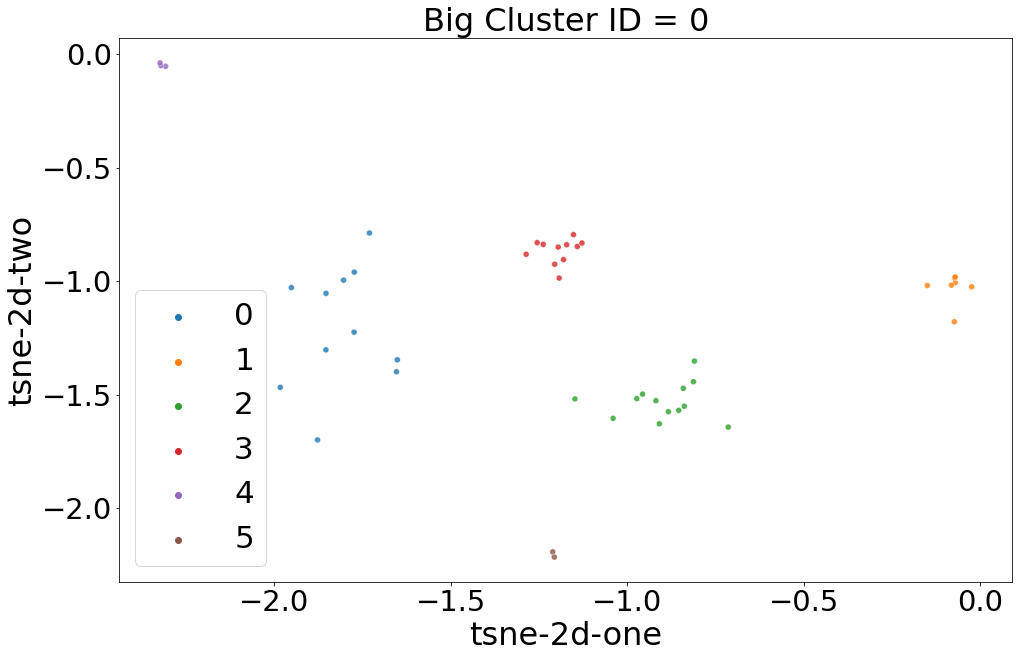

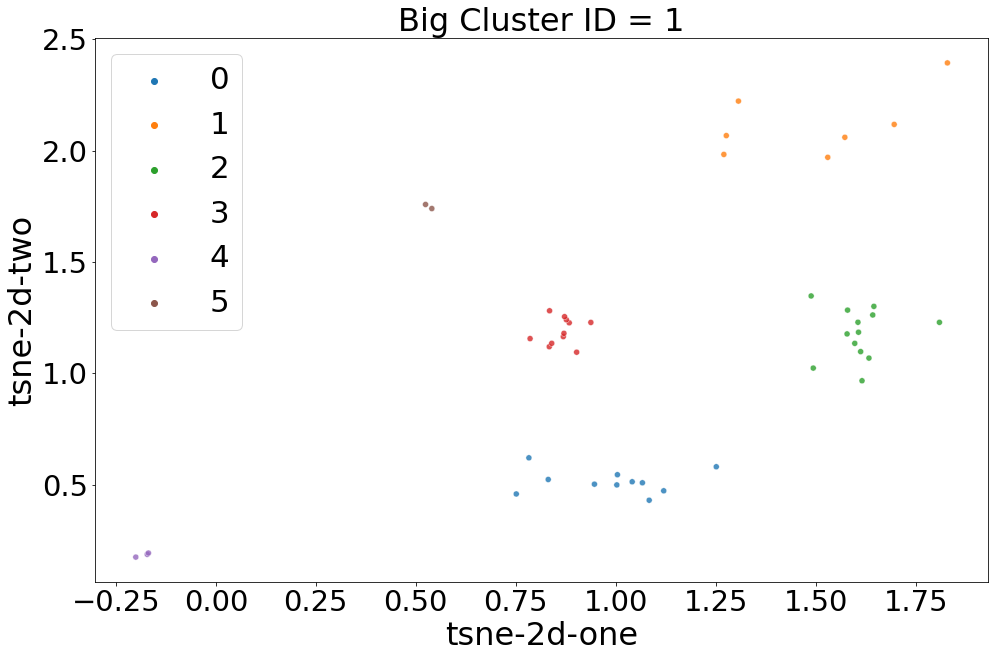

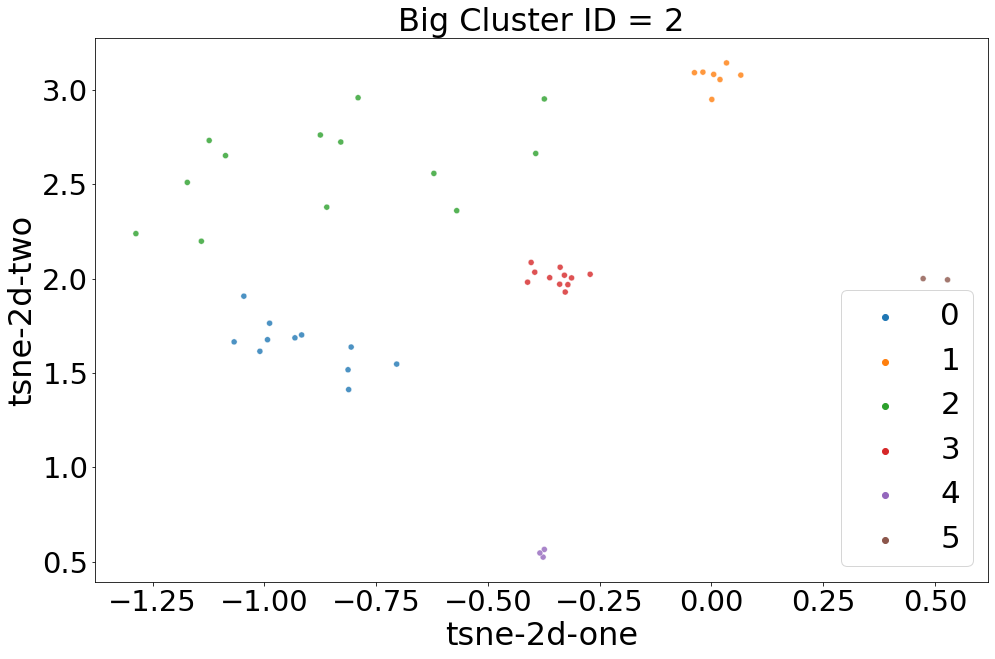

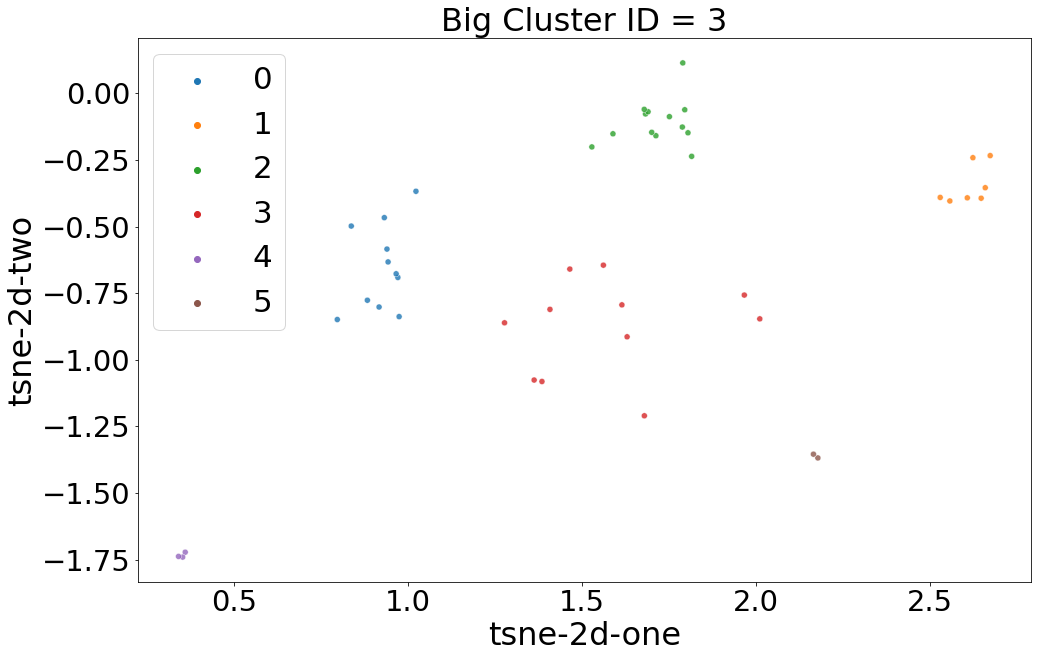

In [22]:
for m in range(len(bigClusterID)):
    '''
    TSNE plot to confirm decreased diameter and better clustering (reducedMH DATA)
    '''
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=600, init='pca', random_state=56, method='exact', learning_rate=75)
    ProcessedTSNE = tsne.fit_transform(subClusterDataList[m])
    df_subset = dict()
    df_subset['tsne-2d-one'] = ProcessedTSNE[:,0]
    df_subset['tsne-2d-two'] = ProcessedTSNE[:,1]
    plt.figure(figsize=(16,10))
    sns.scatterplot(
        x="tsne-2d-one", y="tsne-2d-two",
        hue=subClusterLabelList[m],
        palette=sns.color_palette("tab10", n_clustersMHCL),
        data=df_subset,
        legend="full",
        alpha=0.8
    )
    ax = plt.gca()
    ax.set_title("Big Cluster ID = "+str(bigClusterID[m]))